In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

%matplotlib notebook

import statistics

import csv
import re
from sklearn.cluster import AgglomerativeClustering

In [2]:
import os
import numpy as np
from pygam import LinearGAM, s

from masserstein import Spectrum, estimate_proportions, dualdeconv2

In [3]:
def get_compound_name(filename):
    return re.findall("(.*[a-zA-Z\-])([0-9]*$)", filename[:-4])[0][0]



In [4]:
# Load spectra

def load_spectra(prefix):
    result = []
    names = set()
    for filename in os.listdir(prefix):
        with open(prefix + filename, "r") as infile:
            confs = []
            next(infile) # header
            for line in infile:
                line = line.strip()
                if line != "":
                    line = line.split()
                    line = list(map(float, line))
                    # zakresOD, zakresDO, calka
                    if line[1] != 0:
                        confs.append((line[0], line[1]))
        s = Spectrum(None, empty=True, label=filename)
        s.set_confs(confs)
        result.append(s)
        names.add(get_compound_name(filename))
    return result, names
        
drugs, drugs_names = load_spectra("data/nmr/data/ASCI/leki/")
active, active_names = load_spectra("data/nmr/data/ASCI/czynne/")
nonactive, nonactive_names = load_spectra("data/nmr/data/ASCI/pomocnicze/")

In [5]:
for name in drugs_names:
    print(name)
print(active_names)
print(nonactive_names)

AmoxiklawZaw
Luteina
Amoxycylina
Cordipinr
estrofemmite
DIOHESPANMAX
Ciprobay
Ospamox1000-
Estrofemmitte
Felodypina
DIOSMINEX
Carvedilol123Ratio
Abutol
Buscopan
PropranololWZF
Keflex250Zaw
Sectral
Isradypina
Metoprolol
Propra
Phlebodia
SildenafilActavis
PropranololLaktoza
AmotaxDIS
Viagra
Carvtev
SildenafilBluefish
Lescol
Novamox
Ospamox
{'Carbamazepina', 'estradiol', 'Diosmina', 'SildanafiluCytrynian', 'Chlorotiazyd'}
{'Laktoza1xH2O', 'EUDRAGIT RL', 'Laurylosiarczan sodu', 'Laktoza bezwodna', 'Ultraamylopektyna', 'Celuloza Mikrokrystaliczna', 'hypromeloza', 'SkrobiaKukurydzianaX', 'Kolidon', 'SkrobiaKukurydziana', 'MC', 'EC', 'sacharoza', 'Mannitol', 'HPMC', 'Alginian sodu', 'SkrobiaZiemniaczana', 'Sorbitol', 'GlikolanNaskrobi', 'Stearynian magnezu'}


In [6]:
# one_confs = drugs[0].confs
# diffs = [(v[0], v[1] - one_confs[i-1][1]) for i, v in enumerate(one_confs[1:])]
# diffed_spec = Spectrum(formula=None, empty=True)
# diffed_spec.confs = diffs

In [7]:
# #diffed_spec.plot(profile=True)

# abs_diffs = np.abs(list(zip(*diffs))[1])
# ppm_s, signal = list(zip(*one_confs))
# not_signal_idx = np.where(abs_diffs <= np.quantile(np.abs(list(zip(*diffs))[1]), 0.9))[0]
# not_signal_idx = np.where(signal <= np.quantile(signal, 0.85))[0]
# print(not_signal_idx)

# noise_spec = Spectrum(formula=None, empty=True)
# noise_spec.confs = [one_confs[i] for i in not_signal_idx]
# noise_spec.plot(profile=True)
# ppm_noise, signal_noise = zip(*noise_spec.confs)
# # print(ppm_noise, signal_noise)
# # Spectrum.plot_all([noise_spec, drugs[0]], profile=True)

In [8]:


# gam = LinearGAM(s(0))
# gam.gridsearch(np.array([[i] for i in ppm_noise]), np.asarray(signal_noise))


In [9]:
# gam.summary()
# prediction = gam.predict(X=np.array([[i] for i in ppm_s]))

In [10]:
# baseline_spectrum = Spectrum(formula=None, empty=True, label="cokolwiek")
# baseline_spectrum.confs = [(ppm_s[i], -v) for i, v in enumerate(prediction)]
# # result_spectrum.plot(profile=True)

# result_spectrum = drugs[0] + baseline_spectrum
# result_spectrum.plot(profile=True)
# # Spectrum.plot_all([baseline_spectrum, drugs[0]], profile=True)

In [11]:
# result_spectrum.normalize()
# result_spectrum.cut_smallest_peaks(0.1)

In [12]:
# result_spectrum.plot(profile=True)

In [13]:
def find_baseline(spectrum, save=False, show=False):
    one_confs = spectrum.confs
    diffs = [(v[0], v[1] - one_confs[i - 1][1])
             for i, v in enumerate(one_confs[1:])]
    diffed_spec = Spectrum(formula=None, empty=True)
    diffed_spec.confs = diffs
    abs_diffs = np.abs(list(zip(*diffs))[1])
    ppm_s, signal = list(zip(*one_confs))
    not_signal_idx = np.where(signal <= np.quantile(signal, 0.85))[0]

    noise_spec = Spectrum(formula=None, empty=True)
    noise_spec.confs = [one_confs[i] for i in not_signal_idx]
    ppm_noise, signal_noise = zip(*noise_spec.confs)
    gam = LinearGAM(s(0))
    gam.gridsearch(np.array([[i] for i in ppm_noise]),
                   np.asarray(signal_noise))
    prediction = gam.predict(X=np.array([[i] for i in ppm_s]))
    baseline_spectrum = Spectrum(formula=None, empty=True, label="Baseline")
    baseline_spectrum.confs = [(ppm_s[i], v) for i, v in enumerate(prediction)]

    result_spectrum = spectrum + -1 * baseline_spectrum


    Spectrum.plot_all([baseline_spectrum, spectrum], profile=True, show=show)
    if save:
        plt.savefig("/vagrant/pictures/pic" + spectrum.label + ".pdf")
    return baseline_spectrum, result_spectrum
    
def denoise(spectrum):
    spectrum.normalize()
    spectrum.cut_smallest_peaks(0.1)
    return spectrum

In [14]:
all_spectra = drugs + active + nonactive


def remove_pure_noises(spectra):
    res = []
    inds = []
    
    for i, sp in enumerate(spectra):
        value = abs(max(c[1] for c in sp.confs) / min(c[1] for c in sp.confs))
        if not value < 2:
            res.append(sp)
            inds.append(i)
    return res, inds

all_used_spectra, all_used_inds = remove_pure_noises(all_spectra)

In [14]:
(len(all_used_spectra) ** 2) / 113000 * 3


NameError: name 'all_used_spectra' is not defined

In [15]:
def find_baselines(spectra):
    baselines = []
    debaselined = []
    for sp in spectra:
        b, r = find_baseline(sp, show=False, save=False)
        baselines.append(b)
        debaselined.append(r)
    return baselines, debaselined

# all_used_baselines, all_used_spectra = find_baselines(all_used_spectra)

In [16]:
# # Dump
# import json
# with open("data/nmr/data/debaselined.json", "w") as outfile:
#     json.dump([(spec.label, spec.confs) for spec in all_used_spectra],
#               outfile)

# And load
all_used_spectra = []
import json
with open("data/nmr/data/debaselined.json", "r") as infile:
    data = json.load(infile)
    for d in data:
        sp = Spectrum(formula=None, empty=True, label=d[0])
        sp.confs = d[1]
        all_used_spectra.append(sp)
        

In [17]:
sum(len([1 for c in sp.confs if c[1] <= 0]) for sp in all_used_spectra)

0

In [18]:
# one_s= all_spectra[125]
# one_s.plot()

# from copy import deepcopy
# second_s = deepcopy(one_s)
# print(len(second_s.confs))
# second_s.normalize()
# second_s.cut_smallest_peaks(0.001)
# print(len(second_s.confs))
# second_s.plot()

# for i, sp in enumerate(drugs):
#     value= sum(c[1] for c in sp.confs) / len(sp.confs)
#     if value < 20:
#         print(i, value)
# iter = nonactive
# for i, sp in enumerate(iter):
# #     if sp.label == "Mannitol2.txt":
# #         sp.plot()
# #         print(sum(c[1] for c in sp.confs) / len(sp.confs))
# #         print(max(c[1] for c in sp.confs), min(c[1] for c in sp.confs))
# #         break
#     value = abs(max(c[1] for c in sp.confs) / min(c[1] for c in sp.confs))
#     if value < 2:
#         print(i, value)

# iter[449].plot()
# sum([1 for sp in all_spectra if sum([1 for c in sp.confs if c[1] < 0]) > 0])

In [19]:
from optimal_transport_py import quick_distance

def par_distance(arg):
    i, j = arg
    res = []
    return i, j, quick_distance(all_used_spectra[i], all_used_spectra[j])


def ind_generator():
    count = 0
    for i in range(len(all_used_spectra)):
        for j in range(len(all_used_spectra)):
            count += 1
            if count % 1000 == 0:
                print("Now yielding ", count)
            yield i, j
    return


def own_affinity_paralel():
    import gc
    gc.collect()
    from multiprocessing import Pool
    pool = Pool(2)
    distance_matrix = \
        [[None for y in range(len(all_used_spectra))] for x in range(len(all_used_spectra))]
    for i, j, res in pool.imap_unordered(par_distance, ind_generator(),
                                         chunksize=10):
        distance_matrix[i][j] = res
    return distance_matrix

In [20]:
# # Calc dists matrix and dump
# if __name__ == "__main__":
#     from datetime import datetime
#     start = datetime.now()
#     distance_matrix = own_affinity_paralel()
#     print("Calculated, took", datetime.now() - start)
#     import json
#     with open("data/nmr/data/distances.json", "w") as outfile:
#         json.dump(distance_matrix, outfile)

# And load
with open("data/nmr/data/distances_normalized.json", "r") as infile:
    distance_matrix = json.load(infile)

In [37]:
# Additional preparing
name_to_group = {name: "drugs" for name in drugs_names}
name_to_group.update({name: "active" for name in active_names})
name_to_group.update({name: "nonactive" for name in nonactive_names})

all_used_names = {}
all_used_names["drugs"] = {name: [] for name in drugs_names}
all_used_names["active"] = {name: [] for name in active_names}
all_used_names["nonactive"] = {name: [] for name in nonactive_names}


for i, sp in enumerate(all_used_spectra):
    label = sp.label[:-15]
    name = re.findall("(.*[a-zA-Z\-])([0-9]*$)", label)[0][0]
    all_used_names[name_to_group[name]][name].append(i)

print(all_used_names)

{'drugs': {'AmoxiklawZaw': [222, 265, 325], 'Luteina': [67, 696], 'Amoxycylina': [10, 15, 60, 64, 73, 95, 105, 137, 138, 212, 232, 253, 260, 267, 292, 432, 485, 499, 518, 527, 578, 594, 615, 672, 685, 686, 707, 738, 751], 'Cordipinr': [21, 33, 51, 57, 63, 83, 88, 120, 124, 128, 179, 293, 297, 374, 439, 446, 493, 537, 539, 541, 561, 581, 614, 660, 671, 701, 711, 750], 'estrofemmite': [22, 85, 111, 208, 221, 241, 392, 414, 468, 501, 504, 572, 630, 641, 675, 753], 'DIOHESPANMAX': [34, 52, 163, 188, 215, 218, 227, 301, 314, 316, 334, 354, 412, 422, 437, 478, 489, 496, 543, 570, 579, 589, 612, 613, 623, 636, 661, 716, 724, 726, 747], 'Ciprobay': [717], 'Ospamox1000-': [32, 58, 72, 76, 104, 114, 127, 142, 144, 184, 197, 203, 204, 246, 330, 358, 378, 410, 436, 522, 534, 574, 608, 638, 640, 694, 719], 'Estrofemmitte': [23, 42, 176, 225, 277, 367, 401, 447, 604, 656, 664, 669], 'Felodypina': [16, 46, 79, 80, 89, 103, 116, 157, 162, 180, 183, 195, 196, 229, 288, 294, 327, 429, 435, 458, 459, 488

In [35]:
# Calculate mean distance inside group
inside_distances = {}
for group_name, group in all_used_names.items():
    for compound_name, compound_ids in group.items():
        dist = 0
        numb = 0
        for i_id, i in enumerate(compound_ids):
            for j in compound_ids[i_id:]:
                if i != j:
                    dist += distance_matrix[i][j]
                    numb += 1
#         print(compound_name)
        if numb > 0:
            inside_distances[compound_name] = dist / numb

cross_distances = {}
for group1_name, group1 in all_used_names.items():
    for group2_name, group2 in all_used_names.items():
        if group1_name != group2_name and (group2_name, group1_name) not in cross_distances:
            cross_distances[(group1_name, group2_name)] = {}
            for compound1_name, compound1_ids in group1.items():
                for compound2_name, compound2_ids in group2.items():
                    dist = 0
                    numb = 0
                    for i in compound1_ids:
                        for j in compound2_ids:
                            dist += distance_matrix[i][j]
                            numb += 1
                    if numb > 0:
                        cross_distances[(group1_name, group2_name)][(compound1_name, compound2_name)] = dist / numb            

print(inside_distances)
print(cross_distances.keys())

{'AmoxiklawZaw': 0.7161380109880113, 'Luteina': 0.817908720227046, 'Amoxycylina': 0.37626093086400897, 'Cordipinr': 0.4061793381007485, 'estrofemmite': 0.9105372365320797, 'DIOHESPANMAX': 0.2852483637680292, 'Ospamox1000-': 0.39267383243835324, 'Estrofemmitte': 0.7040972840827535, 'Felodypina': 0.42015535582582536, 'DIOSMINEX': 0.28934173530743174, 'Carvedilol123Ratio': 0.7257864159258293, 'Abutol': 0.2763769535141857, 'Buscopan': 0.5884277085220417, 'PropranololWZF': 0.22303521629222303, 'Keflex250Zaw': 0.39061530470211814, 'Sectral': 0.5148580038247299, 'Isradypina': 0.514978239753316, 'Metoprolol': 0.3064760378551452, 'Propra': 0.4994756192408304, 'Phlebodia': 0.30859934868502586, 'SildenafilActavis': 0.6036825077387148, 'PropranololLaktoza': 0.20699108829601318, 'AmotaxDIS': 0.38623158827579945, 'Viagra': 0.18689850832774904, 'Carvtev': 0.7057747910987762, 'SildenafilBluefish': 0.21618480614534333, 'Lescol': 0.252142700982491, 'Novamox': 0.36066038429478736, 'Ospamox': 0.4830598031

In [23]:
print("Inside groups: ", sum(inside_distances.values()) / len(inside_distances))
print("Max:", max(inside_distances.values()), ", min:", min(inside_distances.values()))

for pair_name, dists in cross_distances.items():
    print("---")
    print(pair_name, ":", sum(dists.values()) / len(dists))
    print("Max:", max(dists.values()), ", min:", min(dists.values()))

Inside groups:  0.47446479806587544
Max: 0.9105372365320797 , min: 0.18689850832774904
---
('drugs', 'active') : 1.5879820598747598
Max: 1.9581323874191963 , min: 0.5525981585946934
---
('drugs', 'nonactive') : 1.4587536807626835
Max: 2.07929818943997 , min: 0.6589674593199815
---
('active', 'nonactive') : 1.7334450291512686
Max: 2.074304635791058 , min: 1.1336803539169378


In [24]:
# 

[Text(0, 0, 'Inside groups'),
 Text(0, 0, 'drugs <-> active'),
 Text(0, 0, 'drugs <-> nonactive'),
 Text(0, 0, 'active <-> nonactive')]

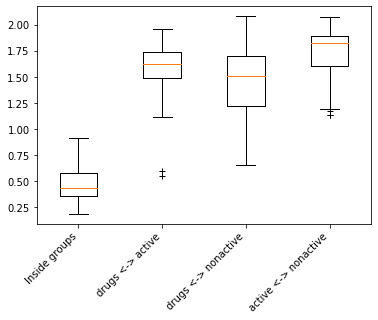

In [25]:
# Boxplots
boxplot_data = [list(inside_distances.values())]
boxplot_labels = ["Inside groups"]
for pair_name, dists in cross_distances.items():
    boxplot_labels.append(" <-> ".join(pair_name))
    boxplot_data.append(list(dists.values()))
    
fig1, ax1 = plt.subplots()
ax1.boxplot(boxplot_data, sym='+')
ax1.set_xticklabels(boxplot_labels, rotation=45, ha="right")

('DIOHESPANMAX', 'Diosmina')
('Estrofemmitte', 'estradiol')
('DIOSMINEX', 'Diosmina')
('Phlebodia', 'Diosmina')
('SildenafilActavis', 'SildanafiluCytrynian')
('Viagra', 'SildanafiluCytrynian')
('SildenafilBluefish', 'SildanafiluCytrynian')
('DIOHESPANMAX', 'Stearynian magnezu')
('Estrofemmitte', 'Laktoza1xH2O')
('Estrofemmitte', 'hypromeloza')
('Estrofemmitte', 'SkrobiaKukurydziana')
('Estrofemmitte', 'HPMC')
('Estrofemmitte', 'Stearynian magnezu')
('DIOSMINEX', 'Laktoza1xH2O')
('DIOSMINEX', 'Celuloza Mikrokrystaliczna')
('DIOSMINEX', 'Stearynian magnezu')
('Phlebodia', 'Celuloza Mikrokrystaliczna')
('Phlebodia', 'hypromeloza')
('SildenafilActavis', 'Laktoza1xH2O')
('SildenafilActavis', 'Celuloza Mikrokrystaliczna')
('SildenafilActavis', 'Kolidon')
('SildenafilActavis', 'Stearynian magnezu')
('Viagra', 'Laktoza1xH2O')
('Viagra', 'Celuloza Mikrokrystaliczna')
('Viagra', 'Stearynian magnezu')
('SildenafilBluefish', 'Laktoza1xH2O')
('SildenafilBluefish', 'Celuloza Mikrokrystaliczna')
('Si

[Text(0, 0, 'Inside all groups'),
 Text(0, 0, 'drugs <-> active'),
 Text(0, 0, 'drugs <-> nonactive'),
 Text(0, 0, 'active <-> nonactive')]

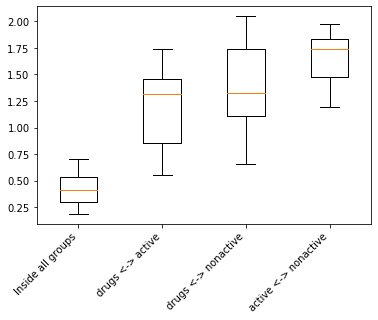

In [36]:
# One more boxplot


substs = [
    ["Estrofemmitte","estradiol","Laktoza1xH2O","SkrobiaKukurydziana","Stearynian magnezu","hypromeloza","HPMC"],
    ["Phlebodia","Diosmina","Celuloza Mikrokrystaliczna","hypromeloza"],
    ["DIOSMINEX","Diosmina","Celuloza Mikrokrystaliczna","Laktoza1xH2O","Stearynian magnezu"],
    ["SildenafilBluefish","SildanafiluCytrynian","Celuloza Mikrokrystaliczna","Stearynian magnezu","Laktoza1xH2O","hypromeloza"],
    ["SildenafilActavis","SildanafiluCytrynian","Laktoza1xH2O","Celuloza Mikrokrystaliczna","Kolidon","Stearynian magnezu","Hypromeloza"],
    ["DIOHESPANMAX","Diosmina","Stearynian magnezu"],
    ["Viagra","SildanafiluCytrynian","Celuloza Mikrokrystaliczna","Stearynian magnezu","Laktoza1xH2O"]
    
]
all_pairs = set([(i, j) for s in substs for i in s for j in s])

boxplot_data = [list(v for k, v in inside_distances.items() if (k, k) in all_pairs)]
boxplot_labels = ["Inside all groups"]
for pair_name, dists in cross_distances.items(): 
    boxplot_labels.append(" <-> ".join(pair_name))
    one_box_data = []
    for pair, dist in dists.items():
        if pair in all_pairs:
            one_box_data.append(dist)
            print(pair)
    boxplot_data.append(one_box_data)
    
fig1, ax1 = plt.subplots()
ax1.boxplot(boxplot_data, sym='+')
ax1.set_xticklabels(boxplot_labels, rotation=45, ha="right")

In [24]:
# Painitng graph
import networkx as nx

In [52]:
g = nx.Graph()

for group in all_used_names:
    for name in all_used_names[group]:

        g.add_node(name, group=group)
        if name in inside_distances:
            g.add_edge(name, name, length=inside_distances[name])

for group in cross_distances:
    for (n1, n2), v in cross_distances[group].items():
        g.add_edge(n1, n2, length=v)


<IPython.core.display.Javascript object>


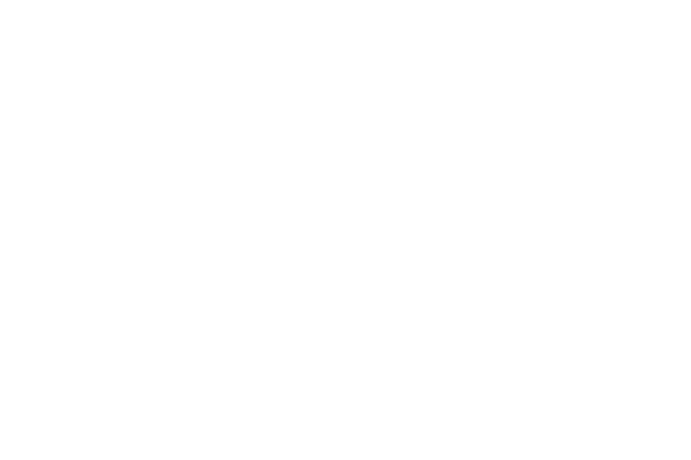

<IPython.core.display.Javascript object>


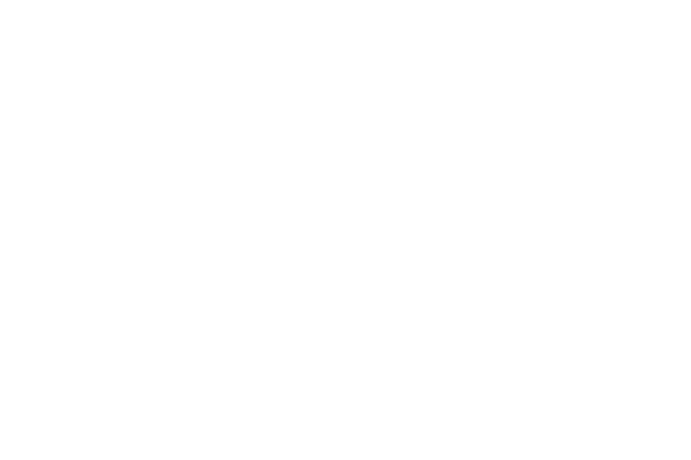

In [64]:
%matplotlib notebook
pos=nx.random_layout(g) # positions for all nodes
# nx.draw(g, pos)
node_colors = ["r" if node[1]["group"] == "active" else ("b" if node[1]["group"] == "nonactive" else "g") for node in g.nodes(data=True)]
nx.draw_networkx_nodes(g, pos, nodelist=[node[0] for node in g.nodes(data=True)], node_color=node_colors, node_size=20)
# nx.draw_networkx_nodes(g, pos, nodelist=[node[0] for node in g.nodes(data=True) if node[1]["group"]=="active"], node_color="b")
# nx.draw_networkx_nodes(g, pos, nodelist=[node[0] for node in g.nodes(data=True) if node[1]["group"]=="nonactive"], node_color="g")
# nx.draw_networkx_labels(g, pos, font_size=8)
nx.draw_networkx_edges(g, pos)
plt.show()

In [41]:
# Export data for picture
with open("data/nmr/data/nodes.csv", "w") as outfile:
    writer = csv.writer(outfile, delimiter="\t")
    writer.writerow(["name", "type"])
    for group in all_used_names:
        for name in all_used_names[group]:
            writer.writerow([name, group])


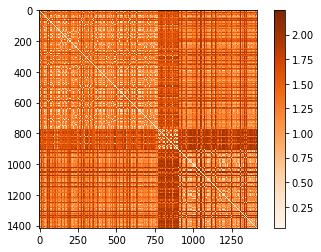

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix, cmap=plt.get_cmap("Oranges"))

fig.colorbar(im)

# fig.tight_layout()
plt.show()


In [55]:
ac = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                             linkage='average', compute_full_tree=True,
                             distance_threshold=1e5)
labels = ac.fit_predict(distance_matrix)


In [56]:
labels.max()

582

In [62]:
clusters = {}

for cluster_nb in range(labels.max()):
    names = [name for label, name in zip(labels, all_used_names) if label == cluster_nb]
    clusters[cluster_nb] = names
    

In [63]:
# TODO podziel substancje na:
# - najpierw kolejne substancje,
# - potem czy są lekami, aktywnymi, pomocniczymi.
# A następnie badaj średnie odległości między substancjami w 1 klastrze i
# średnie odległości między klastrami.

{0: ['Ospamox1000-221', 'Ospamox1000-220'], 1: ['Amoxycylina23', 'Amoxycylina22'], 2: ['Buscopan6', 'Buscopan4', 'Ultraamylopektyna10', 'SkrobiaZiemniaczana23', 'SkrobiaKukurydziana10', 'SkrobiaKukurydziana14', 'MC22', 'SkrobiaKukurydziana9', 'SkrobiaZiemniaczana21', 'SkrobiaKukurydziana13', 'SkrobiaKukurydziana11', 'GlikolanNaskrobi18', 'Ultraamylopektyna15', 'SkrobiaKukurydziana15', 'SkrobiaKukurydziana3', 'SkrobiaZiemniaczana20', 'GlikolanNaskrobi16', 'SkrobiaKukurydziana2', 'Ultraamylopektyna9', 'MC11', 'MC12', 'GlikolanNaskrobi17', 'Ultraamylopektyna16', 'Ultraamylopektyna12', 'GlikolanNaskrobi9', 'Ultraamylopektyna14', 'SkrobiaKukurydziana5', 'SkrobiaKukurydziana12', 'MC13', 'SkrobiaKukurydziana4', 'SkrobiaKukurydziana7', 'MC10', 'Ultraamylopektyna11', 'SkrobiaKukurydziana6', 'SkrobiaKukurydziana16', 'SkrobiaZiemniaczana24', 'Ultraamylopektyna13', 'SkrobiaZiemniaczana22', 'Ultraamylopektyna8', 'MC9', 'SkrobiaKukurydziana17', 'MC14', 'SkrobiaKukurydziana1', 'GlikolanNaskrobi19'], 